<a href="https://colab.research.google.com/github/taimur1871/car_sales_prediction/blob/main/hyperparameter_tuning_car_sales_predictions_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing hyperparameters

### Q: For the Data Science Problem for Tesla, run hyper-parameterization set up to find the optimal parameters for the best regression model. Do this for at least 2 data models and report your results.

The steps are as follows:

1. Divide the training data (Q12 of car sales) into training and validation either randomly or based on the date of orders.

2. Set a range for the hyper-parameters (e.g. number of iterations, s_theta etc for gradient descent, or Lambda values for regularized Normal equations, or different parameter settings for decision trees)

3. Loop through the different hyper parameters to find which hyper-parameter set minimizes error on validation data. Fix the best hyper-parameter set as the one that yields min validation error.

4. Apply the best hyperparameters on test data and report improvements in terms of MSE and R2 metric.



### Import the necessary modules

In [1]:
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read in the CSV file containing the California sales data for Quarters 1 and 2

Then examine the data's shape and first few rows

In [49]:
df_sales = pd.read_csv("Sales_Q12_2019.csv")
print(df_sales.shape)
df_sales.head()

(5837, 76)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP,dealer_state,date
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610,California,2019-04-28
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505,California,2019-03-14
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890,California,2019-06-12
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055,California,2019-03-04
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830,California,2019-01-23


### Begin cleaning the data

Eliminate the `'dealer_state'` and `'date'` columns. The former is useless to our model, since we already know that our dataset is restricted to California sales. While we could possibly extract useful information from the `'date'` column (for example, to determine whether more cars are sold on weekends than weekdays), we'll be focusing on car configurations in this exercise.

In [50]:
df_sales = df_sales.drop(columns=['dealer_state','date'])
df_sales.head()

,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830


## Consolidating data by finding numbers of unique car combinations sold for training and test data sets

Since the data is one hot encoded for various  `'main_type'`, `'engine'`, and `'sales_version'` values. We will group these car sales to find the top selling car in H1, 2019.

The function below will create dataset in the required format.

In [51]:
def get_features_and_targets(df):
   # Create the local data DataFrame as a copy of the input df DataFrame, minus the 'MSRP' column
    data = df.copy()
    data.drop('MSRP', axis=1, inplace=True)
    data_y = data.value_counts(normalize=True, sort=False)
    # Use the value_counts() method for DataFrames to store the targets as a NumPy array of the 
    # normalized sales counts associated with each unique combination of 'main_type', 'engine', 
    # and 'sales_version' values in the data DataFrame
    # Make sure the counts are unsorted, so they're listed in order of the combination's first appearance
    # in the data DataFrame, and that the array is 2D, with 1 entry per row
    Y = data_y.to_numpy()
    Y = Y.reshape(Y.shape[0], 1)
    
    # Get a list of the column names of the data DataFrame
    subset_names = data.columns.values.tolist()
    X = np.array(df.drop_duplicates(subset=subset_names))
    X[:,-1] = ( X[:,-1] - min(X[:,-1]) ) / np.ptp(X[:,-1])
    
    # Return features and targets
    return X, Y

### Spliting data into train and validation sets

In [7]:
from sklearn.model_selection import train_test_split

In [96]:
# Extract training features and targets from the Q12 data
X, Y = get_features_and_targets(df_sales)

# split data
x_train, x_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.2, random_state=42)

print('size x_train = ', len(x_train))
print('size y_train = ', len(y_train))
print('size x_validate = ', len(x_validate))
print('size y_validate = ', len(y_validate))

size x_train =  52
size y_train =  52
size x_validate =  14
size y_validate =  14


### Getting Metrics for Grid Search

In [150]:
from sklearn.metrics import mean_squared_error as MSE

# This function evaluates the R**2 statistic
def r2(Yt,Yp):
    yhat = Yp                         
    ybar = np.sum(Yt)/len(Yt)          
    ssreg = np.sum((yhat-ybar)**2)   
    sstot = np.sum((Yt - ybar)**2)    
    results = ssreg / sstot
    return results

In [151]:
# set up grid search
from sklearn.model_selection import GridSearchCV

## SGD Implementation From In Class Exercise

In [ ]:
s_learning_rate = [x/100 for x in range(1, 10)]
tuned_parameters = [{'s_learning_rate':s_learning_rate}]

In [ ]:
# initiating s_theta as array of zeros
s_theta = np.zeros((x_train.shape[1]+1, 1))

### Functions Needed for Gradient Descent

In [ ]:
# Defining hypothesis function
def h (theta, X):
    tempX = np.append(np.ones((X.shape[0], 1)), X, axis=1)
    return np.matmul(tempX, theta)

# Loss Function
def loss (theta, X, Y):
    return np.average(np.square(Y-h(theta, X)))/2

# gradient calculation
def gradient (theta, X, Y):
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    
    # Compute the gradient
    d_theta = - np.average((Y - h(theta, X)) * tempX, axis= 0)
    d_theta = d_theta.reshape(tempX.shape[1], 1)

    return d_theta

# stochastic gradient descent function
def stochastic_gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    # Initialize the cost as an array of zeros
    cost = np.zeros(max_iteration)

    for i in range(max_iteration):
        for j in range(X.shape[0]):
            # Compute the gradient
            d_theta = gradient(theta, X[j].reshape(1, X.shape[1]), Y[j].reshape(1, Y.shape[1]))
            
            # Update theta
            theta = theta - learning_rate * d_theta
        # Update cost
        cost[i] = loss(theta, X, Y)

        #if i % gap == 0 :
            #print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

In [152]:
# initiate temp variables at high value
mse_temp = 100
r2_temp = 0
lr = 0.0

for i in s_learning_rate:
  s_theta = np.zeros((x_train.shape[1]+1, 1))
  s_theta, s_cost = stochastic_gradient_descent(s_theta, x_train, y_train, i, s_max_iteration, 100)
    
  # calculate on validation dataset
  GD_P = h(s_theta, x_validate)
  GD_P[GD_P<0] = 0

  if mse_temp > MSE(y_validate, GD_P):
    mse_temp = MSE(y_validate, GD_P)
    r2_temp = r2(y_validate, GD_P)
    lr = i

print(lr, mse_temp, r2_temp)

0.01 0.00046856975572656505 0.692214517598009


### Visualize the predicted and actual test labels

Run the model on selected parameters and plot results

RMSE, R2 using SGD= 0.0004755543440926065 0.7280607089706616


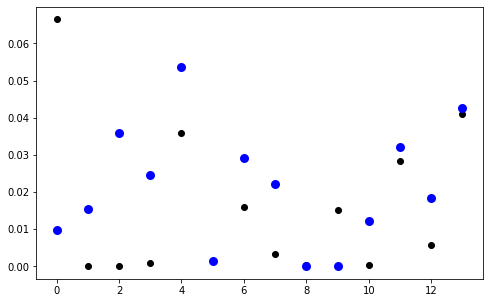

In [154]:
# running the model again on selected parameters and 5x iterations
s_theta = np.zeros((x_train.shape[1]+1, 1))
s_theta, s_cost = stochastic_gradient_descent(s_theta, x_train, y_train, 0.01, 5000, 100)
GD_P = h(s_theta, x_validate)
GD_P[GD_P<0] = 0

plt.figure(figsize=(8,5))
plt.scatter(range(len(y_validate)), y_validate,  color='black')
plt.scatter(range(len(GD_P)), GD_P, color='blue', linewidth=3)

print("RMSE, R2 using SGD=", MSE(y_validate,GD_P), r2(y_validate,GD_P))

## Random Forest Regression

Using the `RandomForestRegressor` from `sklearn.ensemble`.

In [157]:
# creating array for parameters to tune
max_depth = [x for x in range(3, 10)]
tuned_parameters = [{'max_depth':max_depth}]

In [158]:
# scores to optimize for
scores = ['neg_mean_squared_error', 'r2']

In [160]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate gridsearch
for score in scores:
  clf = GridSearchCV(RandomForestRegressor(random_state=0), tuned_parameters, scoring = score)
  clf.fit(x_train, y_train.ravel())

print(clf.best_params_)

{'max_depth': 4}


RMSE, R2 for Decision Trees= 0.0008220150229140628 1.1309399313617257


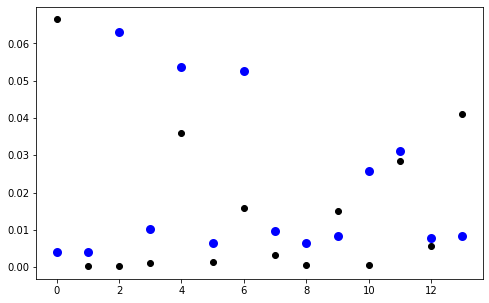

In [161]:
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(x_train, np.ravel(y_train))

# Generate predictions from the test data
pred_rf = regr.predict(x_validate)
pred_rf[np.where(pred_rf<0)]=0

# Plot outputs
plt.figure(figsize=(8,5))
plt.scatter(range(len(y_validate)), y_validate,  color='black')
plt.scatter(range(len(pred_rf)), pred_rf, color='blue', linewidth=3)
print("RMSE, R2 for Decision Trees=", MSE(y_validate,pred_rf), r2(y_validate,pred_rf)) #[Low error high corr]

## Getting Test Data

In [162]:
# Read in the Q34 data
df_pred = pd.read_csv('sales_Q34_2019.csv')

# Examine the first few rows of the data
df_pred.head()

,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,51355
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71580
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66790
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72330
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55370


In [163]:
# Extract training features and targets from the Q12 data
x_test, y_test = get_features_and_targets(df_sales)

print('size x_test = ', len(x_test))
print('size y_test = ', len(y_test))

size x_test =  66
size y_test =  66


### Testing on Gradient Descent

RMSE, R2 using SGD= 0.000407819779438524 0.47575103633142846


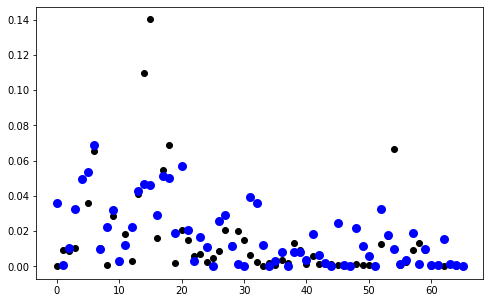

In [164]:
# running the model again on selected parameters and 5x iterations
GD_P_test = h(s_theta, x_test)
GD_P_test[GD_P_test<0] = 0

plt.figure(figsize=(8,5))
plt.scatter(range(len(y_test)), y_test,  color='black')
plt.scatter(range(len(GD_P_test)), GD_P_test, color='blue', linewidth=3)

print("RMSE, R2 using SGD=", MSE(y_test,GD_P_test), r2(y_test,GD_P_test))

### Testing on Random Forest Regressor

RMSE, R2 for Decision Trees= 0.0003145699000761357 0.5736935067476803


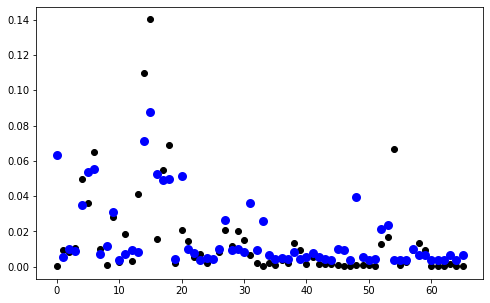

In [165]:
# Generate predictions from the test data
pred_rf_test = regr.predict(x_test)
pred_rf_test[np.where(pred_rf_test<0)]=0

# Plot outputs
plt.figure(figsize=(8,5))
plt.scatter(range(len(y_test)), y_test,  color='black')
plt.scatter(range(len(pred_rf_test)), pred_rf_test, color='blue', linewidth=3)
print("RMSE, R2 for Decision Trees=", MSE(y_test,pred_rf_test), r2(y_test,pred_rf_test))

## Results:

Based on the optimally trained models the results are pretty impressive overall. However both models underpredict when dealing with high volume cars. 

I think one of the ways to improve this would be to analyze only the top 10 or 20 models instead of all the models or see if the features can be futher consolidated. This would hopefully eliminate or consolidate the models with only one or two cars sold into larger categories, thereby reducing the effect of outliers.

# Gradient Descent Linear Using Sklearn

I decided to use sklearn gradient descent for this as well, however an implementation of the in class SGD is also given at the end. This section also includes the class I wrote to try and implement SGD for GridSearchCV from sklearn.

In [ ]:
# trying to create a SGD class with fit function to be able to use the sklearn GridSearch
class SGD(object):
  def __init__(self, theta, X):
    self.theta = theta
    self.X = X

  def fit(self, theta, X):
    temp_X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
    return np.matmul(tempX, theta)

In [ ]:
#s_learning_rate = [x/100 for x in range(1, 10)]
tuned_parameters = [{'alpha':[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]}]

In [ ]:
# scores to optimize for
scores = ['neg_mean_squared_error', 'r2']

In [ ]:
for score in scores:
  clf = GridSearchCV(SGDRegressor(learning_rate='optimal', max_iter=10000), tuned_parameters, scoring= score)
  clf.fit(x_train, y_train.ravel())

In [ ]:
print(clf.best_params_)

{'alpha': 0.003}
